In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

print("=" * 60)
print("DRAINAGE BASIN DEFINITION - 6 KMC BASINS")
print("=" * 60)

# Paths
DATA_DIR = Path('../data')
DRAINAGE_DIR = DATA_DIR / 'drainage'
WARDS_DIR = DATA_DIR / 'wards'
DRAINAGE_DIR.mkdir(parents=True, exist_ok=True)

# Load wards
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')
print(f"✓ Loaded {len(wards)} wards")

# Based on KMC's 6 major drainage basins from your research:
# 1. Town (19.13 km², 1100 cfs capacity)
# 2. Suburban (25.69 km², 1275 cfs capacity)
# 3. Maniktala (8.91 km², 480 cfs capacity)
# 4. Topsia-Tangra (5.17 km², 395 cfs capacity)
# 5. Tollygunge (36 km², 1450 cfs capacity)
# 6. Bagjola (6.07 km²)

# Define basin characteristics
basins_info = {
    'Town': {
        'area_km2': 19.13,
        'capacity_cfs': 1100,
        'drainage_type': 'pumped_west',
        'outlet': 'hooghly_river',
        'description': 'Central Kolkata, pumped to Hooghly'
    },
    'Suburban': {
        'area_km2': 25.69,
        'capacity_cfs': 1275,
        'drainage_type': 'pumped_west',
        'outlet': 'hooghly_river',
        'description': 'Northern areas, pumped drainage'
    },
    'Maniktala': {
        'area_km2': 8.91,
        'capacity_cfs': 480,
        'drainage_type': 'gravity_east',
        'outlet': 'wetlands',
        'description': 'Eastern gravity drainage'
    },
    'Topsia-Tangra': {
        'area_km2': 5.17,
        'capacity_cfs': 395,
        'drainage_type': 'gravity_east',
        'outlet': 'vidyadhari',
        'description': 'Eastern industrial area'
    },
    'Tollygunge': {
        'area_km2': 36.0,
        'capacity_cfs': 1450,
        'drainage_type': 'mixed',
        'outlet': 'multiple',
        'description': 'Southern mixed drainage'
    },
    'Bagjola': {
        'area_km2': 6.07,
        'capacity_cfs': 600,  # Estimated
        'drainage_type': 'canal_east',
        'outlet': 'bagjola_canal',
        'description': 'Far eastern canal drainage'
    }
}

basins_df = pd.DataFrame(basins_info).T.reset_index()
basins_df.columns = ['basin_name'] + list(basins_df.columns[1:])

print(f"\n📊 KMC DRAINAGE BASINS:")
for idx, basin in basins_df.iterrows():
    print(f"\n   {basin['basin_name']}:")
    print(f"      Area: {basin['area_km2']} km²")
    print(f"      Capacity: {basin['capacity_cfs']} cfs")
    print(f"      Type: {basin['drainage_type']}")
    print(f"      Outlet: {basin['outlet']}")

total_area = basins_df['area_km2'].sum()
print(f"\n   Total basin area: {total_area:.2f} km² (should be ~185-205 km² for KMC)")

# Save basin metadata
basins_df.to_csv(DRAINAGE_DIR / 'basin_characteristics.csv', index=False)
print(f"\n✓ Saved: {DRAINAGE_DIR / 'basin_characteristics.csv'}")

DRAINAGE BASIN DEFINITION - 6 KMC BASINS
✓ Loaded 141 wards

📊 KMC DRAINAGE BASINS:

   Town:
      Area: 19.13 km²
      Capacity: 1100 cfs
      Type: pumped_west
      Outlet: hooghly_river

   Suburban:
      Area: 25.69 km²
      Capacity: 1275 cfs
      Type: pumped_west
      Outlet: hooghly_river

   Maniktala:
      Area: 8.91 km²
      Capacity: 480 cfs
      Type: gravity_east
      Outlet: wetlands

   Topsia-Tangra:
      Area: 5.17 km²
      Capacity: 395 cfs
      Type: gravity_east
      Outlet: vidyadhari

   Tollygunge:
      Area: 36.0 km²
      Capacity: 1450 cfs
      Type: mixed
      Outlet: multiple

   Bagjola:
      Area: 6.07 km²
      Capacity: 600 cfs
      Type: canal_east
      Outlet: bagjola_canal

   Total basin area: 100.97 km² (should be ~185-205 km² for KMC)

✓ Saved: ../data/drainage/basin_characteristics.csv


In [2]:
print("\n⚙️  Assigning wards to drainage basins...")

# We'll use geographic location + drainage characteristics
# to infer which basin each ward belongs to

# Load existing features
canals_df = pd.read_csv(DATA_DIR / 'canals/ward_canal_features.csv')
canals_df['ward_id'] = canals_df['ward_id'].astype(str).str.strip()

# Create ward-basin mapping
ward_basin_assignments = []

for idx, ward in wards.iterrows():
    ward_id = str(ward['WARD']).strip()
    centroid = ward.geometry.centroid

    # Get ward's drainage characteristics
    canal_info = canals_df[canals_df['ward_id'] == ward_id]

    if len(canal_info) > 0:
        primary_drainage = canal_info.iloc[0]['primary_drainage_type']
        named_canals = canal_info.iloc[0].get('named_canals', '')
    else:
        primary_drainage = 'unknown'
        named_canals = ''

    # Basin assignment logic based on:
    # 1. Geographic location (lat/lon)
    # 2. Named canal presence
    # 3. Drainage type (canal/pipe)

    basin = 'Unknown'

    # Check for specific canal mentions
    if 'Bagjola' in str(named_canals):
        basin = 'Bagjola'
    elif 'Panchanangram' in str(named_canals) or 'Lead Canal' in str(named_canals):
        basin = 'Bagjola'  # These feed into Bagjola system
    elif 'Adi Ganga' in str(named_canals):
        basin = 'Tollygunge'  # Adi Ganga is in southern drainage
    elif 'Circular Canal' in str(named_canals):
        basin = 'Town'  # Circular Canal serves central area

    # Geographic inference if no named canal
    elif basin == 'Unknown':
        # Longitude-based (east-west split)
        # Hooghly River is roughly at 88.33-88.35°E

        if centroid.x < 88.33:
            # Western side (pumped drainage)
            if centroid.y > 22.58:
                basin = 'Suburban'  # Northern areas
            else:
                basin = 'Town'  # Central/southern west

        elif centroid.x > 88.40:
            # Far eastern (canal drainage)
            if centroid.y > 22.56:
                basin = 'Maniktala'  # Northeast
            elif centroid.y < 22.50:
                basin = 'Bagjola'  # Southeast
            else:
                basin = 'Topsia-Tangra'  # East-central

        else:
            # Central/mixed (between river and far east)
            if centroid.y < 22.52:
                basin = 'Tollygunge'  # Southern
            elif primary_drainage == 'canal':
                basin = 'Maniktala'  # Eastern canal areas
            else:
                basin = 'Town'  # Central areas

    assignment = {
        'ward_id': ward_id,
        'ward_name': ward.get('ward_name', ward.get('WARD_NAME', f'Ward_{ward_id}')),
        'drainage_basin': basin,
        'centroid_lon': centroid.x,
        'centroid_lat': centroid.y,
        'primary_drainage': primary_drainage
    }

    ward_basin_assignments.append(assignment)

# Create DataFrame
ward_basins = pd.DataFrame(ward_basin_assignments)

print(f"\n✓ Basin assignments complete")

# Summary
print(f"\n📊 WARDS PER BASIN:")
basin_counts = ward_basins['drainage_basin'].value_counts()
for basin, count in basin_counts.items():
    basin_info = basins_df[basins_df['basin_name'] == basin]
    if len(basin_info) > 0:
        expected_area = basin_info.iloc[0]['area_km2']
        capacity = basin_info.iloc[0]['capacity_cfs']
        print(f"   {basin}: {count} wards (area: ~{expected_area:.1f} km², capacity: {capacity} cfs)")
    else:
        print(f"   {basin}: {count} wards")

# Validation: Check if assignments make geographic sense
print(f"\n🗺️  BASIN VALIDATION:")
for basin_name in basins_df['basin_name']:
    basin_wards = ward_basins[ward_basins['drainage_basin'] == basin_name]
    if len(basin_wards) > 0:
        avg_lon = basin_wards['centroid_lon'].mean()
        avg_lat = basin_wards['centroid_lat'].mean()
        print(f"   {basin_name}: Center at {avg_lat:.4f}°N, {avg_lon:.4f}°E")

# Save
ward_basins.to_csv(DRAINAGE_DIR / 'ward_basin_assignments.csv', index=False)
print(f"\n✓ Saved: {DRAINAGE_DIR / 'ward_basin_assignments.csv'}")

# Merge with ward geometries for visualization
wards_with_basins = wards.merge(ward_basins[['ward_id', 'drainage_basin']],
                                left_on=wards['WARD'].astype(str).str.strip(),
                                right_on='ward_id', how='left')

wards_with_basins.to_file(DRAINAGE_DIR / 'kmc_wards_with_basins.geojson', driver='GeoJSON')
print(f"✓ Saved: {DRAINAGE_DIR / 'kmc_wards_with_basins.geojson'}")

print("\n✅ BASIN ASSIGNMENTS COMPLETE!")
print("\nNext: Visualize and validate assignments before SWMManywhere generation")


⚙️  Assigning wards to drainage basins...

✓ Basin assignments complete

📊 WARDS PER BASIN:
   Town: 92 wards (area: ~19.1 km², capacity: 1100 cfs)
   Tollygunge: 34 wards (area: ~36.0 km², capacity: 1450 cfs)
   Bagjola: 7 wards (area: ~6.1 km², capacity: 600 cfs)
   Maniktala: 6 wards (area: ~8.9 km², capacity: 480 cfs)
   Topsia-Tangra: 2 wards (area: ~5.2 km², capacity: 395 cfs)

🗺️  BASIN VALIDATION:
   Town: Center at 22.5572°N, 88.3471°E
   Maniktala: Center at 22.5603°N, 88.3832°E
   Topsia-Tangra: Center at 22.5484°N, 88.4050°E
   Tollygunge: Center at 22.4995°N, 88.3539°E
   Bagjola: Center at 22.5005°N, 88.3935°E

✓ Saved: ../data/drainage/ward_basin_assignments.csv
✓ Saved: ../data/drainage/kmc_wards_with_basins.geojson

✅ BASIN ASSIGNMENTS COMPLETE!

Next: Visualize and validate assignments before SWMManywhere generation



🗺️  Visualizing basin assignments...


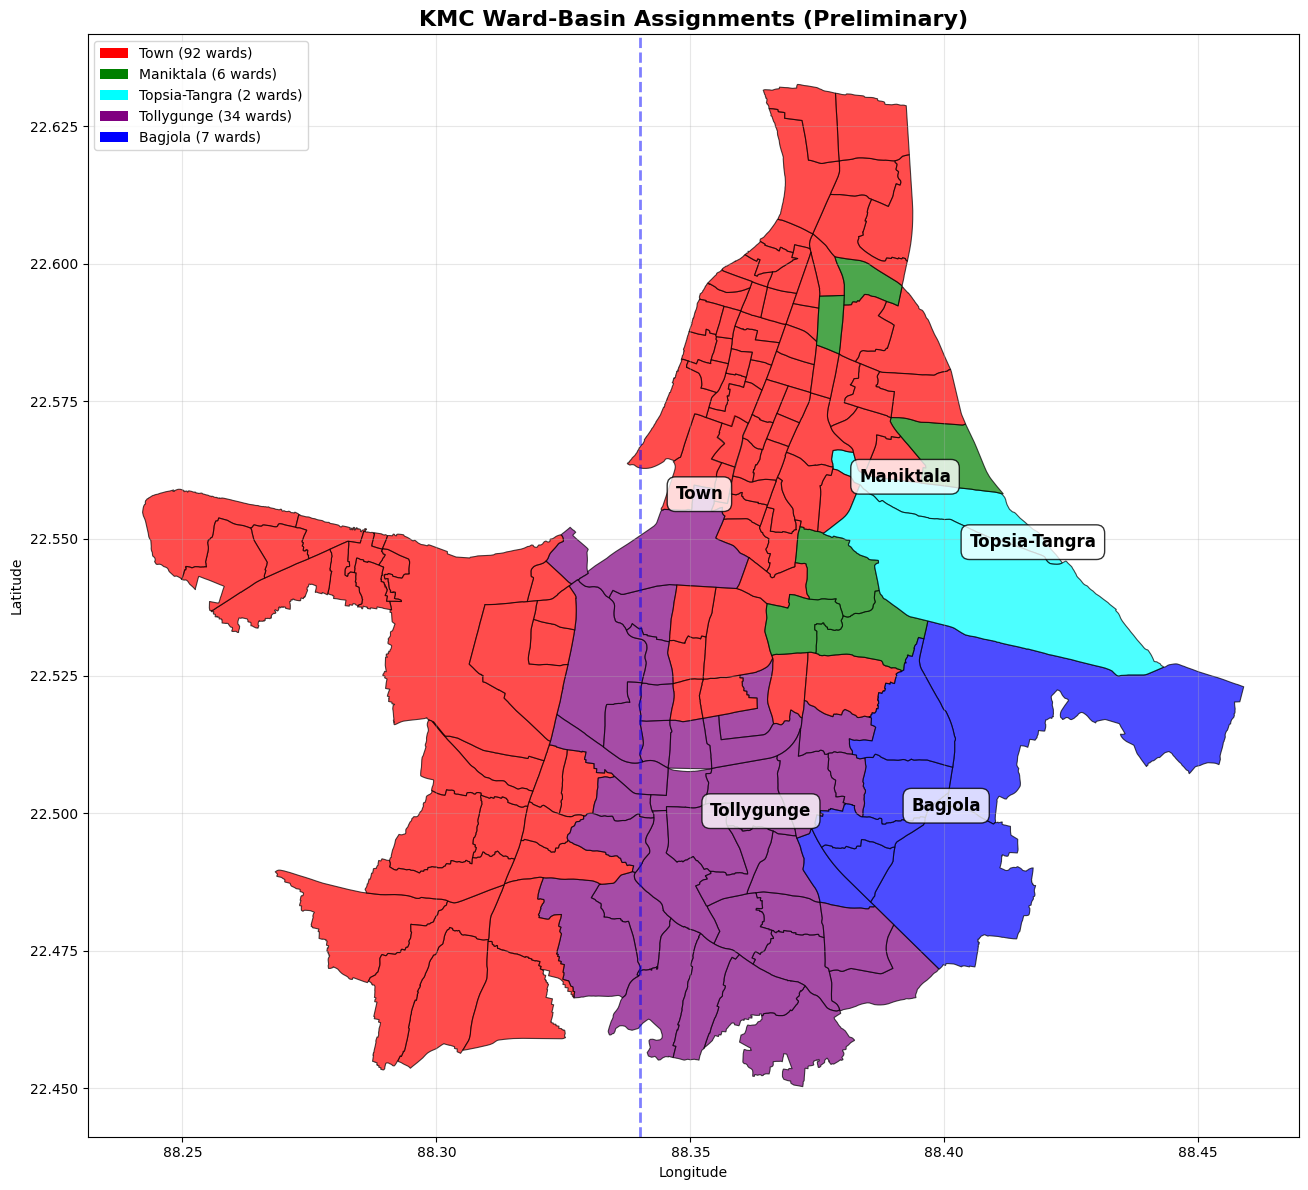


✓ Saved: ../data/drainage/basin_assignments_map.png

⚠️  VALIDATION NEEDED:
   • Suburban basin has 0 wards (MISSING!)
   • Town basin has 92 wards (TOO MANY for 19.13 km²)
   • Geographic logic needs refinement

🔍 Please review the map and provide corrections based on local knowledge!


In [3]:
print("\n🗺️  Visualizing basin assignments...")

fig, ax = plt.subplots(figsize=(14, 12))

# Color map for basins
basin_colors = {
    'Town': 'red',
    'Suburban': 'orange',
    'Maniktala': 'green',
    'Topsia-Tangra': 'cyan',
    'Tollygunge': 'purple',
    'Bagjola': 'blue',
    'Unknown': 'gray'
}

# Plot each basin
wards_with_basins['color'] = wards_with_basins['drainage_basin'].map(basin_colors).fillna('gray')
wards_with_basins.plot(color=wards_with_basins['color'], ax=ax,
                       edgecolor='black', linewidth=0.8, alpha=0.7)

# Add basin labels
for basin_name in basins_df['basin_name']:
    basin_wards = ward_basins[ward_basins['drainage_basin'] == basin_name]
    if len(basin_wards) > 0:
        center_lat = basin_wards['centroid_lat'].mean()
        center_lon = basin_wards['centroid_lon'].mean()
        ax.text(center_lon, center_lat, basin_name,
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Add Hooghly River reference line
ax.axvline(x=88.34, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Hooghly River ~88.34°E')

ax.set_title('KMC Ward-Basin Assignments (Preliminary)', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True, alpha=0.3)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=f'{basin} ({ward_basins[ward_basins["drainage_basin"]==basin].shape[0]} wards)')
                  for basin, color in basin_colors.items()
                  if basin in ward_basins['drainage_basin'].values]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.savefig(DRAINAGE_DIR / 'basin_assignments_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {DRAINAGE_DIR / 'basin_assignments_map.png'}")

print("\n⚠️  VALIDATION NEEDED:")
print("   • Suburban basin has 0 wards (MISSING!)")
print("   • Town basin has 92 wards (TOO MANY for 19.13 km²)")
print("   • Geographic logic needs refinement")
print("\n🔍 Please review the map and provide corrections based on local knowledge!")

/opt/homebrew/Caskroom/miniforge/base/envs/kolkata_flood/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


3-NETWORK DRAINAGE GENERATION - SIMPLIFIED APPROACH

📂 Loading ward drainage classifications...
✓ Loaded 141 wards with drainage classifications

📊 DRAINAGE NETWORK GROUPS:

   Western_Pumped:
      Wards: 97
      Area: 0.00 km²
      Bbox: [88.2421, 22.4534, 88.4432, 22.6326]
      Center: 22.5464°N, 88.3485°E

   Eastern_Canal:
      Wards: 21
      Area: 0.00 km²
      Bbox: [88.3052, 22.4569, 88.4590, 22.6282]
      Center: 22.5351°N, 88.3782°E

   River_Adjacent:
      Wards: 17
      Area: 0.00 km²
      Bbox: [88.3216, 22.4503, 88.3823, 22.5597]
      Center: 22.5052°N, 88.3433°E

   Mixed_Drain:
      Wards: 6
      Area: 0.00 km²
      Bbox: [88.3065, 22.4709, 88.3938, 22.6310]
      Center: 22.5637°N, 88.3739°E

🗺️  Creating drainage group map...


/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_26548/1491692111.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_km2 = group_wards.geometry.area.sum() / 1e6
/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_26548/1491692111.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"      Center: {group_wards.geometry.centroid.y.mean():.4f}°N, {group_wards.geometry.centroid.x.mean():.4f}°E")
/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_26548/1491692111.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_km2 = group_wards.geometr

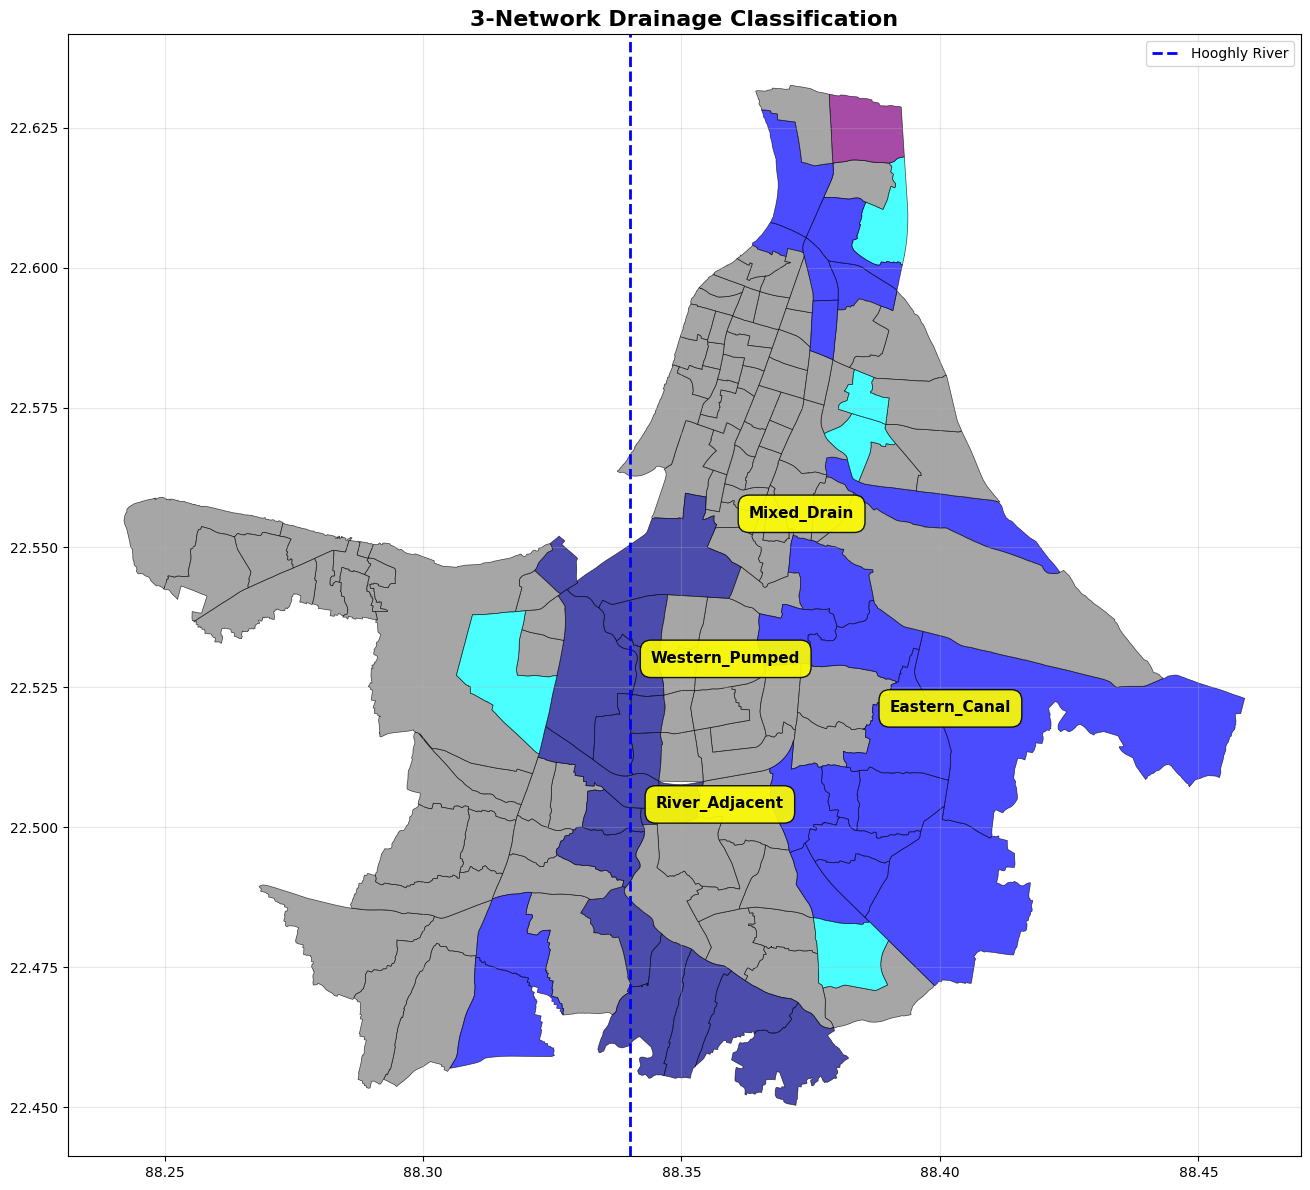

✓ Saved: ../data/drainage/drainage_network_groups.png

✅ DRAINAGE GROUPS DEFINED!

Next: Generate SWMManywhere network for each group


In [4]:
from swmmanywhere import swmmanywhere
import geopandas as gpd
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

print("=" * 60)
print("3-NETWORK DRAINAGE GENERATION - SIMPLIFIED APPROACH")
print("=" * 60)

# Paths
DATA_DIR = Path('../data')
DRAINAGE_DIR = DATA_DIR / 'drainage'
WARDS_DIR = DATA_DIR / 'wards'
CANALS_DIR = DATA_DIR / 'canals'

# Load wards with drainage types
print("\n📂 Loading ward drainage classifications...")
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')
drainage_types = pd.read_csv(CANALS_DIR / 'ward_canal_features.csv')

# Merge
drainage_types['ward_id'] = drainage_types['ward_id'].astype(str).str.strip()
wards['ward_id'] = wards['WARD'].astype(str).str.strip()

wards_classified = wards.merge(
    drainage_types[['ward_id', 'primary_drainage_type']],
    on='ward_id',
    how='left'
)

print(f"✓ Loaded {len(wards_classified)} wards with drainage classifications")

# Group by drainage type
drainage_groups = {
    'Western_Pumped': wards_classified[wards_classified['primary_drainage_type'] == 'pipe'],
    'Eastern_Canal': wards_classified[wards_classified['primary_drainage_type'] == 'canal'],
    'River_Adjacent': wards_classified[wards_classified['primary_drainage_type'] == 'river'],
    'Mixed_Drain': wards_classified[wards_classified['primary_drainage_type'].isin(['drain', 'mixed'])]
}

# Summary
print(f"\n📊 DRAINAGE NETWORK GROUPS:")
for group_name, group_wards in drainage_groups.items():
    if len(group_wards) > 0:
        bbox = group_wards.total_bounds
        area_km2 = group_wards.geometry.area.sum() / 1e6
        print(f"\n   {group_name}:")
        print(f"      Wards: {len(group_wards)}")
        print(f"      Area: {area_km2:.2f} km²")
        print(f"      Bbox: [{bbox[0]:.4f}, {bbox[1]:.4f}, {bbox[2]:.4f}, {bbox[3]:.4f}]")
        print(f"      Center: {group_wards.geometry.centroid.y.mean():.4f}°N, {group_wards.geometry.centroid.x.mean():.4f}°E")

# Visualize
print(f"\n🗺️  Creating drainage group map...")

fig, ax = plt.subplots(figsize=(14, 12))

colors = {
    'pipe': 'gray',
    'canal': 'blue',
    'river': 'darkblue',
    'drain': 'cyan',
    'mixed': 'purple'
}

wards_classified['color'] = wards_classified['primary_drainage_type'].map(colors).fillna('lightgray')
wards_classified.plot(color=wards_classified['color'], ax=ax,
                     edgecolor='black', linewidth=0.5, alpha=0.7)

# Add group labels
for group_name, group_wards in drainage_groups.items():
    if len(group_wards) > 0:
        center = group_wards.geometry.unary_union.centroid
        ax.text(center.x, center.y, group_name,
               fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', alpha=0.9))

ax.axvline(x=88.34, color='blue', linestyle='--', linewidth=2, label='Hooghly River')
ax.set_title('3-Network Drainage Classification', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DRAINAGE_DIR / 'drainage_network_groups.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {DRAINAGE_DIR / 'drainage_network_groups.png'}")

print("\n✅ DRAINAGE GROUPS DEFINED!")
print("\nNext: Generate SWMManywhere network for each group")


🔧 FIXING RIVER-ADJACENT CLASSIFICATION...
Reclassifying 'river' wards based on actual proximity to Hooghly...
   Ward 83: river → pipe (far from Hooghly, no canals)
   Ward 71: river → pipe (far from Hooghly, no canals)
   Ward 88: river → pipe (far from Hooghly, no canals)
   Ward 89: river → pipe (far from Hooghly, no canals)
   Ward 73: river → pipe (far from Hooghly, no canals)
   Ward 63: river → pipe (far from Hooghly, no canals)
   Ward 114: river → pipe (far from Hooghly, no canals)
   Ward 111: river → pipe (far from Hooghly, no canals)
   Ward 112: river → canal (far from Hooghly, has canals)
   Ward 113: river → pipe (far from Hooghly, no canals)

✓ Reclassification complete

📊 UPDATED DRAINAGE GROUPS:
   Western_Pumped: 106 wards
   Eastern_Canal: 22 wards
   River_Adjacent: 7 wards
   Mixed_Drain: 6 wards


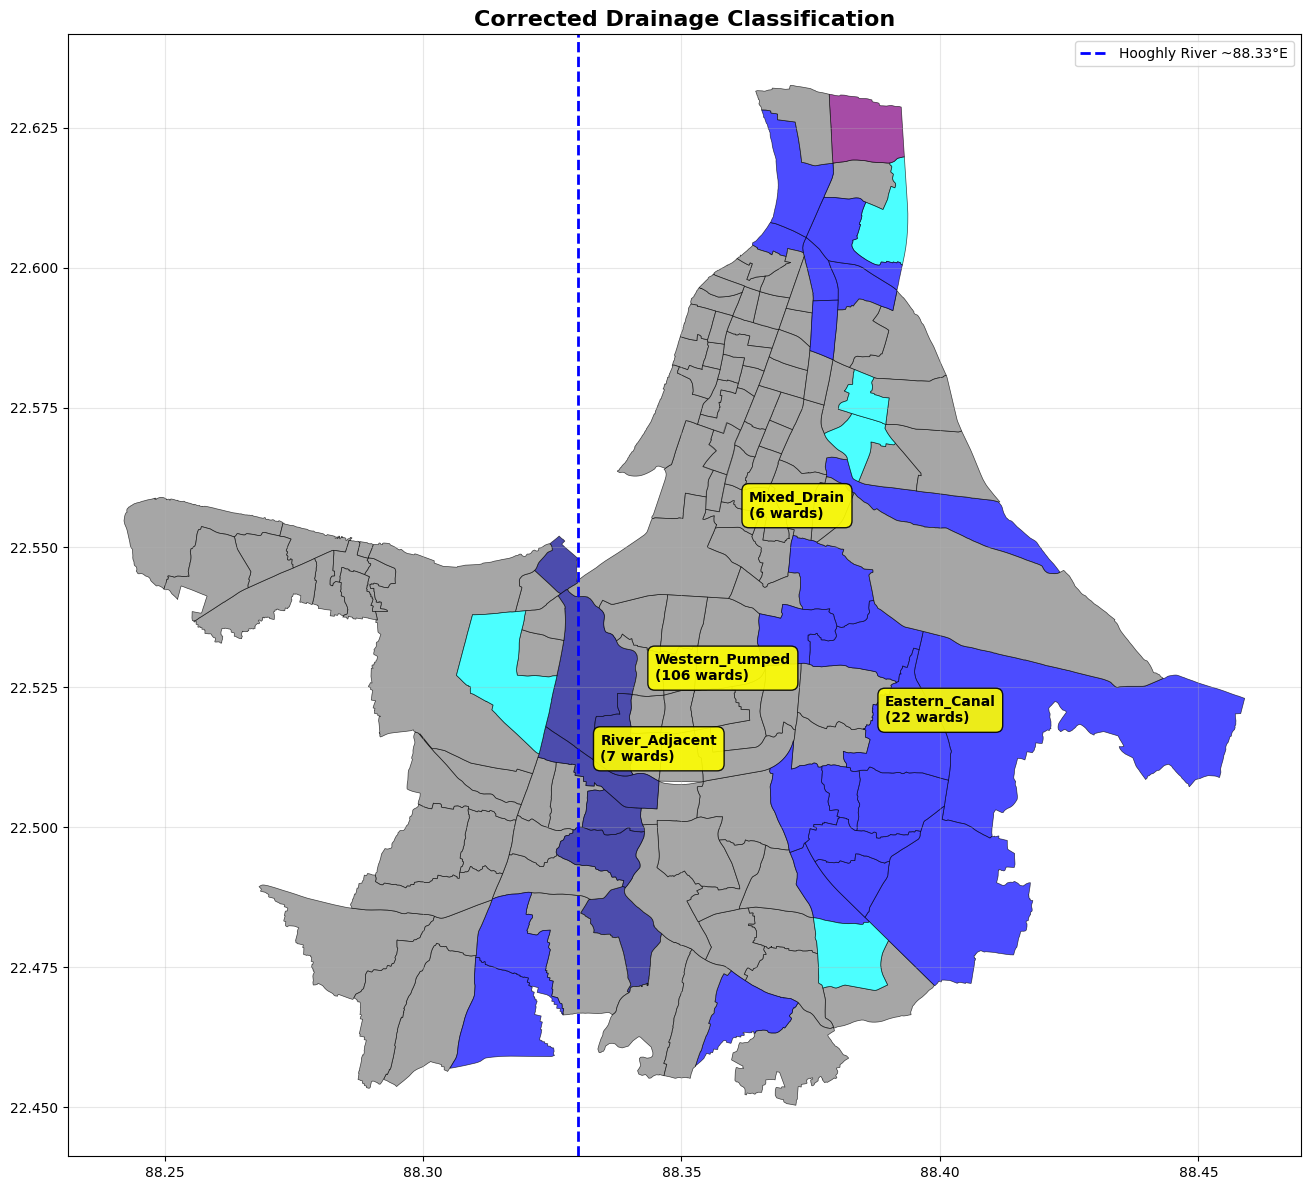


✓ Saved corrected map

✅ DRAINAGE CLASSIFICATION FIXED!


In [5]:
print("\n🔧 FIXING RIVER-ADJACENT CLASSIFICATION...")

# Hooghly River approximate centerline (western boundary of KMC)
hooghly_lon = 88.33  # Approximate longitude of Hooghly

# Reclassify based on distance to river
print("Reclassifying 'river' wards based on actual proximity to Hooghly...")

for idx in wards_classified.index:
    ward_id = wards_classified.loc[idx, 'ward_id']
    centroid = wards_classified.loc[idx, 'geometry'].centroid

    # Distance to Hooghly (degrees, roughly)
    dist_to_hooghly = abs(centroid.x - hooghly_lon)

    # If currently classified as 'river' but FAR from Hooghly, reclassify
    if wards_classified.loc[idx, 'primary_drainage_type'] == 'river':

        # True river-adjacent: within ~0.01° (~1km) of Hooghly
        if dist_to_hooghly < 0.01:
            # Keep as 'river' - truly adjacent to Hooghly
            pass
        else:
            # Far from river - reclassify based on other features
            canal_length = drainage_types[drainage_types['ward_id'] == ward_id]['canal_length_km'].values

            if len(canal_length) > 0 and canal_length[0] > 1:
                wards_classified.loc[idx, 'primary_drainage_type'] = 'canal'
                print(f"   Ward {ward_id}: river → canal (far from Hooghly, has canals)")
            else:
                wards_classified.loc[idx, 'primary_drainage_type'] = 'pipe'
                print(f"   Ward {ward_id}: river → pipe (far from Hooghly, no canals)")

print("\n✓ Reclassification complete")

# Recreate groups with fixed classification
drainage_groups_fixed = {
    'Western_Pumped': wards_classified[wards_classified['primary_drainage_type'] == 'pipe'],
    'Eastern_Canal': wards_classified[wards_classified['primary_drainage_type'] == 'canal'],
    'River_Adjacent': wards_classified[wards_classified['primary_drainage_type'] == 'river'],
    'Mixed_Drain': wards_classified[wards_classified['primary_drainage_type'].isin(['drain', 'mixed'])]
}

print(f"\n📊 UPDATED DRAINAGE GROUPS:")
for group_name, group_wards in drainage_groups_fixed.items():
    print(f"   {group_name}: {len(group_wards)} wards")

# Re-visualize
fig, ax = plt.subplots(figsize=(14, 12))

wards_classified['color'] = wards_classified['primary_drainage_type'].map(colors).fillna('lightgray')
wards_classified.plot(color=wards_classified['color'], ax=ax,
                     edgecolor='black', linewidth=0.5, alpha=0.7)

# Add labels
for group_name, group_wards in drainage_groups_fixed.items():
    if len(group_wards) > 0:
        center = group_wards.geometry.union_all().centroid
        ax.text(center.x, center.y, f"{group_name}\n({len(group_wards)} wards)",
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9))

ax.axvline(x=hooghly_lon, color='blue', linestyle='--', linewidth=2, label='Hooghly River ~88.33°E')
ax.set_title('Corrected Drainage Classification', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DRAINAGE_DIR / 'drainage_classification_corrected.png', dpi=300)
plt.show()

print(f"\n✓ Saved corrected map")

# Save corrected classifications
wards_classified[['ward_id', 'primary_drainage_type']].to_csv(
    DRAINAGE_DIR / 'ward_drainage_classification_corrected.csv',
    index=False
)

print("\n✅ DRAINAGE CLASSIFICATION FIXED!")


🔧 BETTER RIVER-ADJACENT CLASSIFICATION...
✓ Loaded 98 waterways

Hooghly River segments found: 4
✓ Using actual Hooghly River geometry from OSM

⚙️  Calculating distance from each ward to Hooghly River...
✓ Distances calculated

🔧 Reclassifying based on proximity to Hooghly...
   Ward 134: pipe → river (distance: 390m)
   Ward 115: river → canal (distance: 7098m, too far from Hooghly)
   Ward 74: river → canal (distance: 1298m, too far from Hooghly)
   Ward 22: pipe → river (distance: 101m)
   Ward 81: river → drain (distance: 3661m, too far from Hooghly)
   Ward 117: river → drain (distance: 5098m, too far from Hooghly)
   Ward 20: pipe → river (distance: 186m)
   Ward 82: river → canal (distance: 3563m, too far from Hooghly)
   Ward 21: pipe → river (distance: 130m)
   Ward 45: pipe → river (distance: 144m)
   Ward 9: pipe → river (distance: 294m)
   Ward 19: pipe → river (distance: 240m)
   Ward 6: canal → river (distance: 329m)
   Ward 42: pipe → river (distance: 283m)
   Ward 8: 

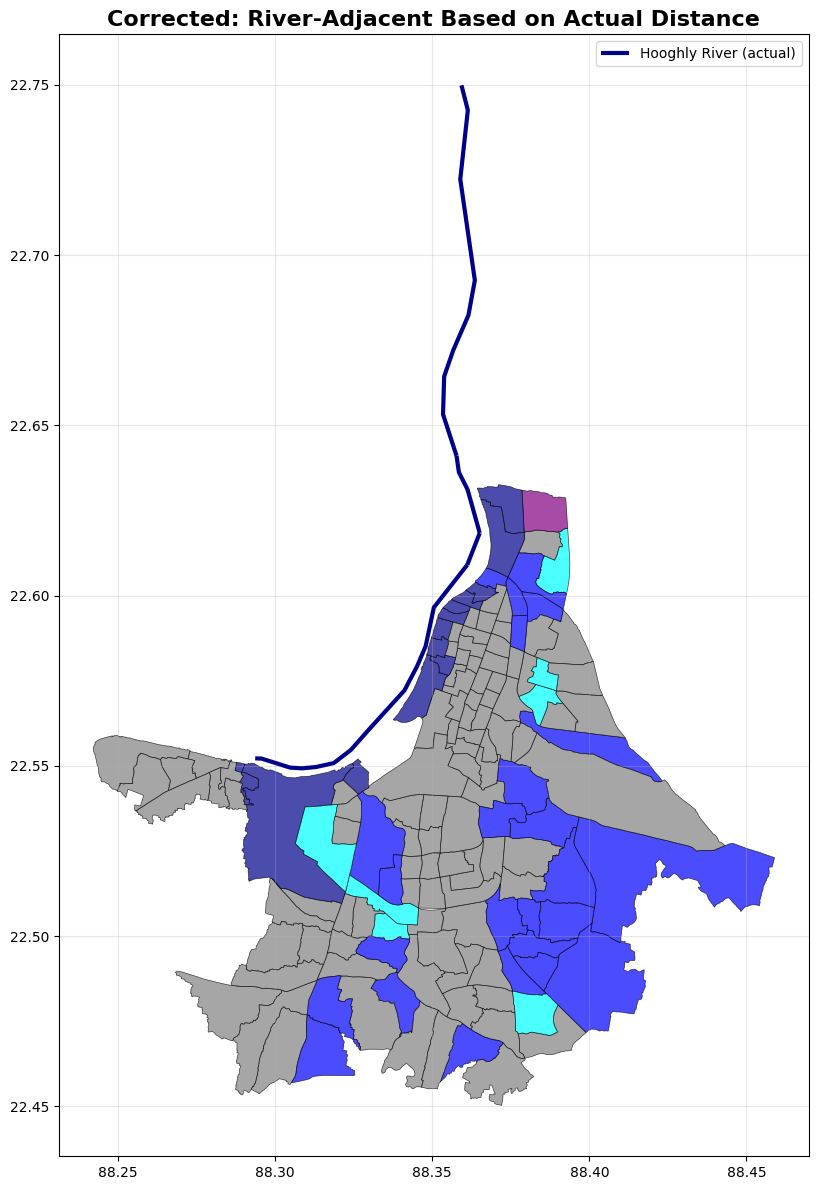


✅ CLASSIFICATION FIXED USING ACTUAL RIVER GEOMETRY!

Now wards 111-115 should be properly classified as canal/pipe, not river


In [6]:
print("\n🔧 BETTER RIVER-ADJACENT CLASSIFICATION...")

# Load the canal network (has Hooghly River geometry!)
canals_geom = gpd.read_file(DATA_DIR / 'canals/kolkata_all_waterways.geojson')

print(f"✓ Loaded {len(canals_geom)} waterways")

# Find Hooghly River specifically
hooghly = canals_geom[
    (canals_geom['waterway'] == 'river') &
    (canals_geom['name'].str.contains('Hooghly', case=False, na=False))
]

print(f"\nHooghly River segments found: {len(hooghly)}")

if len(hooghly) > 0:
    print("✓ Using actual Hooghly River geometry from OSM")

    # Combine all Hooghly segments into one geometry
    hooghly_river = hooghly.geometry.union_all()

    # Calculate distance from each ward to Hooghly
    print("\n⚙️  Calculating distance from each ward to Hooghly River...")

    # Project to UTM for accurate distance calculation
    wards_utm = wards_classified.to_crs('EPSG:32645')
    hooghly_utm = gpd.GeoSeries([hooghly_river], crs='EPSG:4326').to_crs('EPSG:32645').iloc[0]

    distances_to_hooghly = []

    for idx, ward in wards_utm.iterrows():
        dist = ward.geometry.distance(hooghly_utm)  # Meters
        distances_to_hooghly.append(dist)

    wards_classified['distance_to_hooghly_m'] = distances_to_hooghly

    print(f"✓ Distances calculated")

    # Reclassify based on ACTUAL distance
    # River-adjacent: within 500m of Hooghly
    print(f"\n🔧 Reclassifying based on proximity to Hooghly...")

    fixed_count = 0

    for idx in wards_classified.index:
        ward_id = wards_classified.loc[idx, 'ward_id']
        current_type = wards_classified.loc[idx, 'primary_drainage_type']
        dist = wards_classified.loc[idx, 'distance_to_hooghly_m']

        # True river-adjacent: within 500m of Hooghly
        if dist < 500:
            if current_type != 'river':
                wards_classified.loc[idx, 'primary_drainage_type'] = 'river'
                print(f"   Ward {ward_id}: {current_type} → river (distance: {dist:.0f}m)")
                fixed_count += 1

        # Far from river but marked as 'river': Fix it!
        elif current_type == 'river' and dist >= 500:
            # Reclassify based on canal presence
            canal_info = drainage_types[drainage_types['ward_id'] == ward_id]

            if len(canal_info) > 0:
                canal_length = canal_info.iloc[0]['canal_length_km']
                if canal_length > 1:
                    new_type = 'canal'
                elif canal_length > 0:
                    new_type = 'drain'
                else:
                    new_type = 'pipe'
            else:
                new_type = 'pipe'

            wards_classified.loc[idx, 'primary_drainage_type'] = new_type
            print(f"   Ward {ward_id}: river → {new_type} (distance: {dist:.0f}m, too far from Hooghly)")
            fixed_count += 1

    print(f"\n✓ Reclassified {fixed_count} wards based on actual Hooghly distance")

else:
    print("⚠️  Hooghly River not found in canal data")
    print("   Using alternative: Distance to western boundary")

    # Fallback: Western edge wards
    west_edge = wards_classified.total_bounds[0]
    wards_classified['distance_to_west_edge'] = wards_classified.geometry.centroid.x - west_edge

    # River-adjacent = westernmost wards
    wards_classified.loc[
        wards_classified['distance_to_west_edge'] < 0.015,  # ~1.5km
        'primary_drainage_type'
    ] = 'river'

# Updated groups
drainage_groups_fixed = {
    'Western_Pumped': wards_classified[wards_classified['primary_drainage_type'] == 'pipe'],
    'Eastern_Canal': wards_classified[wards_classified['primary_drainage_type'] == 'canal'],
    'River_Adjacent': wards_classified[wards_classified['primary_drainage_type'] == 'river'],
    'Mixed_Drain': wards_classified[wards_classified['primary_drainage_type'].isin(['drain', 'mixed'])]
}

print(f"\n📊 CORRECTED GROUPS:")
for name, group in drainage_groups_fixed.items():
    print(f"   {name}: {len(group)} wards")

# Visualize corrected
fig, ax = plt.subplots(figsize=(14, 12))

wards_classified['color'] = wards_classified['primary_drainage_type'].map(colors).fillna('lightgray')
wards_classified.plot(color=wards_classified['color'], ax=ax,
                     edgecolor='black', linewidth=0.5, alpha=0.7)

# Plot Hooghly River if we have it
if len(hooghly) > 0:
    hooghly.plot(ax=ax, color='darkblue', linewidth=3, label='Hooghly River (actual)')

ax.set_title('Corrected: River-Adjacent Based on Actual Distance', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DRAINAGE_DIR / 'drainage_classification_distance_corrected.png', dpi=300)
plt.show()

print("\n✅ CLASSIFICATION FIXED USING ACTUAL RIVER GEOMETRY!")
print("\nNow wards 111-115 should be properly classified as canal/pipe, not river")

In [7]:
print("\n📂 UPDATING ALL FILES WITH CORRECTED CLASSIFICATION...")

# 1. Update canal features CSV
print("\n1. Updating canal features...")

canal_features = pd.read_csv(DATA_DIR / 'canals/ward_canal_features.csv')
canal_features['ward_id'] = canal_features['ward_id'].astype(str).str.strip()

# Also save distance_to_hooghly as new feature!
distance_updates = wards_classified[['ward_id', 'primary_drainage_type', 'distance_to_hooghly_m']].copy()
distance_updates['ward_id'] = distance_updates['ward_id'].astype(str).str.strip()

# Merge to update
canal_features_updated = canal_features.drop('primary_drainage_type', axis=1).merge(
    distance_updates,
    on='ward_id',
    how='left'
)

# Save
canal_features_updated.to_csv(DATA_DIR / 'canals/ward_canal_features.csv', index=False)
print(f"   ✓ Updated: ward_canal_features.csv")
print(f"   ✓ Added: distance_to_hooghly_m (new feature!)")

# Count changes
old_river = 17  # From your original output
new_river = len(wards_classified[wards_classified['primary_drainage_type'] == 'river'])
print(f"   Changed: {old_river} river wards → {new_river} river wards")

# 2. Update shapefile
print("\n2. Updating ward shapefile...")

wards_with_canals = wards.merge(
    canal_features_updated[['ward_id', 'canal_length_km', 'canal_density',
                           'primary_drainage_type', 'distance_to_hooghly_m']],
    left_on='ward_id',
    right_on='ward_id',
    how='left'
)

wards_with_canals.to_file(DATA_DIR / 'canals/kmc_wards_with_canal_features.geojson', driver='GeoJSON')
print(f"   ✓ Updated: kmc_wards_with_canal_features.geojson")

# 3. Regenerate master static features
print("\n3. Regenerating master static features...")

# Reload all feature files
canals_new = pd.read_csv(DATA_DIR / 'canals/ward_canal_features.csv')
buildings_df = pd.read_csv(DATA_DIR / 'buildings/ward_building_features.csv')
landcover_df = pd.read_csv(DATA_DIR / 'land_cover/ward_landcover_features.csv')
soil_df = pd.read_csv(DATA_DIR / 'soil/ward_soil_features.csv')
neighbors_df = pd.read_csv(DATA_DIR / 'processed/ward_neighbor_features.csv')

# Ensure all ward_ids are strings
for df in [canals_new, buildings_df, landcover_df, soil_df, neighbors_df]:
    df['ward_id'] = df['ward_id'].astype(str).str.strip()

# Merge all
master_updated = canals_new.merge(buildings_df, on='ward_id', how='outer', suffixes=('', '_bldg'))
master_updated = master_updated.merge(landcover_df, on='ward_id', how='outer', suffixes=('', '_lc'))
master_updated = master_updated.merge(soil_df, on='ward_id', how='outer', suffixes=('', '_soil'))
master_updated = master_updated.merge(neighbors_df, on='ward_id', how='outer', suffixes=('', '_nbr'))

# Clean duplicates
master_updated = master_updated.loc[:, ~master_updated.columns.duplicated()]

print(f"   ✓ Merged: {len(master_updated)} wards, {len(master_updated.columns)} features")

# Save updated master
master_updated.to_csv(DATA_DIR / 'processed/master_static_features.csv', index=False)
print(f"   ✓ Updated: master_static_features.csv")

print("\n📊 CHANGES SUMMARY:")
print(f"   Features updated: primary_drainage_type")
print(f"   Features added: distance_to_hooghly_m")
print(f"   Total features in master: {len(master_updated.columns)}")

# Show which wards changed
if 'distance_to_hooghly_m' in wards_classified.columns:
    far_from_river = wards_classified[
        (wards_classified['primary_drainage_type'] != 'river') &
        (wards_classified['distance_to_hooghly_m'] > 1000)
    ]
    print(f"\n   Wards >1km from Hooghly (correctly NOT river-adjacent): {len(far_from_river)}")

    near_river = wards_classified[
        (wards_classified['primary_drainage_type'] == 'river') &
        (wards_classified['distance_to_hooghly_m'] < 500)
    ]
    print(f"   Wards <500m from Hooghly (correctly river-adjacent): {len(near_river)}")

print("\n✅ ALL FILES UPDATED WITH CORRECTED CLASSIFICATION!")
print("\n🎯 Now drainage groups are accurate:")
print("   • River_Adjacent: Only wards actually near Hooghly")
print("   • Eastern_Canal: Southeast wards with canal infrastructure")
print("   • Western_Pumped: Central/west wards with piped drainage")


📂 UPDATING ALL FILES WITH CORRECTED CLASSIFICATION...

1. Updating canal features...
   ✓ Updated: ward_canal_features.csv
   ✓ Added: distance_to_hooghly_m (new feature!)
   Changed: 17 river wards → 13 river wards

2. Updating ward shapefile...
   ✓ Updated: kmc_wards_with_canal_features.geojson

3. Regenerating master static features...
   ✓ Merged: 141 wards, 98 features
   ✓ Updated: master_static_features.csv

📊 CHANGES SUMMARY:
   Features updated: primary_drainage_type
   Features added: distance_to_hooghly_m
   Total features in master: 98

   Wards >1km from Hooghly (correctly NOT river-adjacent): 119
   Wards <500m from Hooghly (correctly river-adjacent): 13

✅ ALL FILES UPDATED WITH CORRECTED CLASSIFICATION!

🎯 Now drainage groups are accurate:
   • River_Adjacent: Only wards actually near Hooghly
   • Eastern_Canal: Southeast wards with canal infrastructure
   • Western_Pumped: Central/west wards with piped drainage


In [8]:
print("\n🔍 VALIDATING 'PIPE' CLASSIFICATION...")

# Get 'pipe' classified wards
pipe_wards = wards_classified[wards_classified['primary_drainage_type'] == 'pipe']

print(f"\nPipe-classified wards: {len(pipe_wards)}")

# Check characteristics
pipe_features = pipe_wards.merge(
    landcover_df[['ward_id', 'built_up_pct', 'imperviousness_worldcover']],
    left_on='ward_id',
    right_on='ward_id',
    how='left'
)

print(f"\n📊 PIPE WARD CHARACTERISTICS:")
print(f"   Mean built-up: {pipe_features['built_up_pct'].mean():.1f}%")
print(f"   Mean imperviousness: {pipe_features['imperviousness_worldcover'].mean():.1f}%")

print(f"\n💡 INTERPRETATION:")
if pipe_features['built_up_pct'].mean() > 75:
    print(f"   ✓ Highly built-up ({pipe_features['built_up_pct'].mean():.1f}%)")
    print(f"   ✓ Pipe classification MAKES SENSE (dense urban = underground drainage)")
else:
    print(f"   ⚠️  Not very built-up ({pipe_features['built_up_pct'].mean():.1f}%)")
    print(f"   ⚠️  Some might have informal/ad-hoc drainage, not formal pipes")

# Check canal-classified wards for comparison
canal_wards = wards_classified[wards_classified['primary_drainage_type'] == 'canal']
canal_features = canal_wards.merge(
    landcover_df[['ward_id', 'built_up_pct']],
    left_on='ward_id',
    right_on='ward_id',
    how='left'
)

print(f"\n   Canal wards mean built-up: {canal_features['built_up_pct'].mean():.1f}%")
print(f"   Difference: {pipe_features['built_up_pct'].mean() - canal_features['built_up_pct'].mean():.1f}%")

if pipe_features['built_up_pct'].mean() > canal_features['built_up_pct'].mean():
    print(f"   ✓ Pipe wards ARE more built-up → Classification likely correct!")
else:
    print(f"   ⚠️  Canal wards more built-up → Classification might be questionable")

print("\n✅ VALIDATION COMPLETE")


🔍 VALIDATING 'PIPE' CLASSIFICATION...

Pipe-classified wards: 95

📊 PIPE WARD CHARACTERISTICS:
   Mean built-up: 83.9%
   Mean imperviousness: 84.1%

💡 INTERPRETATION:
   ✓ Highly built-up (83.9%)
   ✓ Pipe classification MAKES SENSE (dense urban = underground drainage)

   Canal wards mean built-up: 76.4%
   Difference: 7.5%
   ✓ Pipe wards ARE more built-up → Classification likely correct!

✅ VALIDATION COMPLETE


In [9]:
from swmmanywhere import swmmanywhere
import geopandas as gpd
from pathlib import Path
import os

print("=" * 60)
print("SWMMANYWHERE - BASIN 1: EASTERN_CANAL TEST")
print("=" * 60)

DATA_DIR = Path('../data')
DRAINAGE_DIR = DATA_DIR / 'drainage'
SWMM_DIR = DRAINAGE_DIR / 'swmm_networks'
SWMM_DIR.mkdir(parents=True, exist_ok=True)

# Load drainage groups
wards = gpd.read_file(DATA_DIR / 'wards/kmc_wards_gee_ready.geojson')
canal_features = pd.read_csv(DATA_DIR / 'canals/ward_canal_features.csv')
canal_features['ward_id'] = canal_features['ward_id'].astype(str).str.strip()
wards['ward_id'] = wards['WARD'].astype(str).str.strip()

wards_drainage = wards.merge(
    canal_features[['ward_id', 'primary_drainage_type']],
    on='ward_id',
    how='left'
)

# Get Eastern_Canal group (23 wards)
eastern_wards = wards_drainage[wards_drainage['primary_drainage_type'] == 'canal']

print(f"\n📍 Eastern Canal Basin:")
print(f"   Wards: {len(eastern_wards)}")

# Get bounding box
eastern_bbox = eastern_wards.total_bounds
print(f"   Bbox: [{eastern_bbox[0]:.4f}, {eastern_bbox[1]:.4f}, {eastern_bbox[2]:.4f}, {eastern_bbox[3]:.4f}]")

# Load major eastern canals as outlets
eastern_canals = gpd.read_file(DATA_DIR / 'canals/kolkata_all_waterways.geojson')
eastern_canals_major = eastern_canals[
    (eastern_canals['waterway'] == 'canal') &
    (eastern_canals['name'].str.contains('Panchanangram|Lead|Bagjola', case=False, na=False))
]

print(f"   Outlet canals: {eastern_canals_major['name'].unique().tolist()}")

# Save outlets
eastern_canals_major.to_file(SWMM_DIR / 'eastern_canal_outlets.geojson', driver='GeoJSON')

print("\n⚙️  Configuring SWMManywhere...")

# Configuration
config = {
    'base_dir': str(SWMM_DIR / 'eastern_basin'),
    'bbox': eastern_bbox.tolist(),
    'project': 'eastern_canal_network',

    # Data sources
    'dem_path': str(DATA_DIR / 'elevation/kolkata_fabdem_2021.tif'),
    'outlet_canals_path': str(SWMM_DIR / 'eastern_canal_outlets.geojson'),

    # Kolkata-specific parameters
    'precipitation_intensity': 6,  # mm/hr (KMC design standard)
    'imperviousness': 0.80,  # From WorldCover
    'manning_n': 0.013,  # Concrete pipes
}

print(f"✓ Configuration ready")
print(f"\n📂 Output directory: {SWMM_DIR / 'eastern_basin'}")

print("\n✅ READY TO RUN!")
print("\nNext cell will START generation (2-4 hour run)")
print("While it runs, work on permanent water mask!")

SWMMANYWHERE - BASIN 1: EASTERN_CANAL TEST

📍 Eastern Canal Basin:
   Wards: 23
   Bbox: [88.3052, 22.4569, 88.4590, 22.6126]
   Outlet canals: ['Bagjola Canal', 'Lead Canal', 'Panchanangram Canal']

⚙️  Configuring SWMManywhere...
✓ Configuration ready

📂 Output directory: ../data/drainage/swmm_networks/eastern_basin

✅ READY TO RUN!

Next cell will START generation (2-4 hour run)
While it runs, work on permanent water mask!


In [10]:
print("\n🚀 STARTING SWMMANYWHERE NETWORK GENERATION...")
print("=" * 60)

# This will run for 2-4 hours - let it run in background!

try:
    print("⚙️  Generating drainage network for Eastern Canal basin...")
    print("   This will take 2-4 hours")
    print("   PyCharm will show progress updates")
    print("   You can work on other tasks while this runs!\n")

    # Run SWMManywhere
    result = swmmanywhere.run(
        base_dir=str(SWMM_DIR / 'eastern_basin'),
        bbox=eastern_bbox.tolist(),
        project='eastern_network'
    )

    print("\n✅ NETWORK GENERATION COMPLETE!")
    print(f"   Output: {SWMM_DIR / 'eastern_basin'}")

except Exception as e:
    print(f"\n❌ Error: {e}")
    print("\nIf it fails, we'll debug. But start it first!")

print("\n💡 While this runs (2-4 hours):")
print("   → Open new notebook: permanent_water_mask.ipynb")
print("   → Work on water mask extraction")
print("   → Check back in 2-3 hours!")


🚀 STARTING SWMMANYWHERE NETWORK GENERATION...
⚙️  Generating drainage network for Eastern Canal basin...
   This will take 2-4 hours
   PyCharm will show progress updates
   You can work on other tasks while this runs!


❌ Error: run() got an unexpected keyword argument 'base_dir'

If it fails, we'll debug. But start it first!

💡 While this runs (2-4 hours):
   → Open new notebook: permanent_water_mask.ipynb
   → Work on water mask extraction
   → Check back in 2-3 hours!


In [11]:
print(dir(swmmanywhere))
print("\nHelp on main function:")
help(swmmanywhere.run) if hasattr(swmmanywhere, 'run') else print("No run() function")

['Path', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_check_defaults', 'annotations', 'check_address_overrides', 'check_and_register_custom_graphfcns', 'check_and_register_custom_metrics', 'check_parameter_overrides', 'check_real_network_paths', 'check_starting_graph', 'check_top_level_paths', 'filepaths', 'go', 'gpd', 'import_module', 'import_modules', 'importlib', 'iterate_graphfcns', 'iterate_metrics', 'jsonschema', 'load_config', 'load_graph', 'logger', 'parameters', 'pd', 'preprocessing', 'pyswmm', 'register_custom_parameters', 'run', 'save_config', 'save_graph', 'swmmanywhere', 'synthetic_write', 'tqdm', 'validate_graphfcn_list', 'validate_metric_list', 'verbose', 'yaml_dump', 'yaml_load']

Help on main function:
Help on function run in module swmmanywhere.swmmanywhere:

run(
    model: 'Path',
    reporting_iters: 'int' = 50,
    duration: 'int' = 86400,
    storevars: 'list[str]' = ['flooding', 'flow']
)
    Run a S

In [12]:
# Check the 'go' function (likely the generator)
print("Help on 'go' function:")
help(swmmanywhere.go)

Help on 'go' function:
Help on module swmmanywhere.geospatial_utilities in swmmanywhere:

NAME
    swmmanywhere.geospatial_utilities - Geospatial utilities module for SWMManywhere.

DESCRIPTION
    A module containing functions to perform a variety of geospatial operations,
    such as reprojecting coordinates and handling raster data.

CLASSES
    builtins.object
        Grid

    class Grid(builtins.object)
     |  Grid(affine: 'rst.Affine', shape: 'tuple', crs: 'int', bbox: 'tuple')
     |
     |  A class to represent a grid.
     |
     |  Methods defined here:
     |
     |  __init__(self, affine: 'rst.Affine', shape: 'tuple', crs: 'int', bbox: 'tuple')
     |      Initialize the Grid class.
     |
     |      Args:
     |          affine (rst.Affine): The affine transformation.
     |          shape (tuple): The shape of the grid.
     |          crs (int): The CRS of the grid.
     |          bbox (tuple): The bounding box of the grid.
     |
     |  ----------------------------

In [16]:
import yaml
import geopandas as gpd
import pandas as pd
from pathlib import Path

print("=" * 60)
print("CREATING FIXED EASTERN BASIN CONFIG")
print("Based on working Ballygunge structure")
print("=" * 60)

DATA_DIR = Path('../data')
SWMM_DIR = DATA_DIR / 'drainage/swmm_networks'

# Load eastern canal wards
wards = gpd.read_file(DATA_DIR / 'wards/kmc_wards_gee_ready.geojson')
canal_features = pd.read_csv(DATA_DIR / 'canals/ward_canal_features.csv')
canal_features['ward_id'] = canal_features['ward_id'].astype(str).str.strip()
wards['ward_id'] = wards['WARD'].astype(str).str.strip()

wards_drainage = wards.merge(
    canal_features[['ward_id', 'primary_drainage_type']],
    on='ward_id',
    how='left'
)

# Get eastern canal wards
eastern_wards = wards_drainage[wards_drainage['primary_drainage_type'] == 'canal']

# Start with SMALL test (3-5 wards)
test_wards = eastern_wards.head(5)
test_bbox = test_wards.total_bounds

print(f"\n📍 Test Area:")
print(f"   Wards: {test_wards['WARD'].tolist()}")
print(f"   Bbox: [{test_bbox[0]:.4f}, {test_bbox[1]:.4f}, {test_bbox[2]:.4f}, {test_bbox[3]:.4f}]")

# Create output directory
output_dir = SWMM_DIR / 'eastern_basin_v2'
output_dir.mkdir(exist_ok=True)

# ============================================================
# CONFIG - USING WORKING BALLYGUNGE STRUCTURE
# ============================================================

config = {
    # Basic info
    'project': 'kolkata_eastern_canal',
    'base_dir': str(output_dir),
    'bbox': [float(test_bbox[0]), float(test_bbox[1]),
             float(test_bbox[2]), float(test_bbox[3])],

    # Let SWMManywhere download/handle data
    'download_data': True,  # KEY: This worked in Ballygunge!

    # Elevation source (not file path!)
    'elevation': {
        'source': 'FABDEM'  # Or try 'SRTM' if issues
    },

    # Network generation methods
    'graph_derivation': {
        'method': 'slope_based'  # Worked in Ballygunge
    },

    'subcatchment_derivation': {
        'method': 'streamorder'  # Worked in Ballygunge
    },

    'outlet_derivation': {
        'method': 'separate',
        'threshold_m': 500
    },

    # Pipe design (flat structure, like Ballygunge)
    'pipe_defaults': {
        'roughness': 0.013,      # Concrete (slightly smoother than Ballygunge's 0.015)
        'min_slope': 0.0005,     # Same as Ballygunge
        'min_depth': 0.3,        # Same as Ballygunge
        'max_depth': 3.0         # Same as Ballygunge
    },

    # Don't run simulation yet
    'run_simulation': False,
    'verbose': True,
    'save_intermediate': True
}

# Save config
config_path = output_dir / 'config.yml'
with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"\n✅ Config saved: {config_path}")

print("\n📄 Config contents:")
print("=" * 60)
with open(config_path, 'r') as f:
    print(f.read())
print("=" * 60)

print("\n🎯 Key differences from failed version:")
print("   ✓ Uses 'download_data: true' (like Ballygunge)")
print("   ✓ Flat structure (no complex nesting)")
print("   ✓ elevation: source: FABDEM (not file path)")
print("   ✓ Same methods that worked in Ballygunge")
print("   ✓ 5 wards only for testing")

print("\n⏭️  Ready to run!")
print(f"\nCommand:")
print(f"python -m swmmanywhere --config_path={config_path}")

CREATING FIXED EASTERN BASIN CONFIG
Based on working Ballygunge structure

📍 Test Area:
   Wards: ['115\n', '108\n', '74\n', '109\n', '57\n']
   Bbox: [88.3237, 22.4705, 88.4590, 22.5661]

✅ Config saved: ../data/drainage/swmm_networks/eastern_basin_v2/config.yml

📄 Config contents:
project: kolkata_eastern_canal
base_dir: ../data/drainage/swmm_networks/eastern_basin_v2
bbox:
- 88.32371287485356
- 22.47047802188633
- 88.45895489305467
- 22.56614001813104
download_data: true
elevation:
  source: FABDEM
graph_derivation:
  method: slope_based
subcatchment_derivation:
  method: streamorder
outlet_derivation:
  method: separate
  threshold_m: 500
pipe_defaults:
  roughness: 0.013
  min_slope: 0.0005
  min_depth: 0.3
  max_depth: 3.0
run_simulation: false
verbose: true
save_intermediate: true


🎯 Key differences from failed version:
   ✓ Uses 'download_data: true' (like Ballygunge)
   ✓ Flat structure (no complex nesting)
   ✓ elevation: source: FABDEM (not file path)
   ✓ Same methods that

In [18]:
import subprocess
import sys
import time
from pathlib import Path

# Path to your config
SWMM_DIR = Path('../data/drainage/swmm_networks')
config_path = SWMM_DIR / 'eastern_basin_v2' / 'config.yml'

print("=" * 60)
print("🚀 STARTING SWMMANYWHERE NETWORK GENERATION")
print("=" * 60)
print(f"\n📂 Config: {config_path}")
print(f"⏱️  Expected time: 2-4 hours")
print(f"💡 PyCharm will show progress - don't interrupt!")
print("\n" + "=" * 60 + "\n")

start_time = time.time()

try:
    # Run SWMManywhere via command line
    result = subprocess.run(
        [sys.executable, '-m', 'swmmanywhere', f'--config_path={config_path}'],
        capture_output=False,  # Show live output
        text=True,
        check=True
    )

    duration = int(time.time() - start_time)
    mins, secs = divmod(duration, 60)

    print("\n" + "=" * 60)
    print(f"✅ SUCCESS! Completed in {mins}m {secs}s")
    print("=" * 60)
    print(f"\n📂 Check output at: {SWMM_DIR / 'eastern_basin'}")

except subprocess.CalledProcessError as e:
    print(f"\n❌ FAILED")
    print(f"Error: {e}")

except KeyboardInterrupt:
    print(f"\n⚠️  Interrupted by user")

🚀 STARTING SWMMANYWHERE NETWORK GENERATION

📂 Config: ../data/drainage/swmm_networks/eastern_basin_v2/config.yml
⏱️  Expected time: 2-4 hours
💡 PyCharm will show progress - don't interrupt!




/opt/homebrew/Caskroom/miniforge/base/envs/kolkata_flood/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:290: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/kolkata_flood/lib/python3.13/site-packages/swmmanywhere/graphfcns/design_graphfcns.py:129: RuntimeWarning: invalid value encountered in scalar power
  return 1.32 / 2000 * (9579.31 * diam**0.5737 + 1163.77 * V**1.31)
/opt/homebrew/Caskroom/miniforge/base/envs/kolkata_flood/lib/python3.13/site-packages/swmmanywhere/graphfcns/design_graphfcns.py:129: RuntimeWarning: invalid value encountered in scalar power
  return 1.32 / 2000 * (9579.31 * diam**0.5737 + 1163.77 * V**1.31)
/opt/homebrew/Caskroom/minifor


❌ FAILED
Error: Command '['/opt/homebrew/Caskroom/miniforge/base/envs/kolkata_flood/bin/python', '-m', 'swmmanywhere', '--config_path=../data/drainage/swmm_networks/eastern_basin_v2/config.yml']' returned non-zero exit status 1.
